# 🦠 Emergent Molecular Communication

A preliminary study of emergent molecular communication protocols learned by graph-based agents in a diffusion channel environment.

## Table of Contents
- [Imports](#introduction)
- [Utils](#utils)
  - [Data](#data)
  - [Neural Networks](#neural-networks)
  - [Communication Model](#communication-model)
  - [Train the Communication Model](#train-the-communication-model)
- [Running the Experiments](#running-the-experiments)
  - [Experiments on Ideal and Diffusion Channel](#experiments-on-ideal-and-diffusion-channel)
  - [Experiments on Pure Relay Nodes](#experiments-on-pure-relay-nodes)
- [Collect and Visualize Results](#collect-and-visualize-results)

## Imports

In [1]:
import os
from typing import Optional
import warnings
from copy import deepcopy
import logging
from logging import getLogger
import math
import random
from random import shuffle
from itertools import product
from datetime import datetime
import glob
from functools import cache

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.special import erfc
from ucimlrepo import fetch_ucirepo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import ray

sns.set_style("whitegrid")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = getLogger(__name__)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42);

## Utils

### Data

In [3]:
def generate_graph(
    n_nodes: int, density: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Generate random (x, y) positions for nodes in a graph.

    The nodes are uniformly distributed in a square region.
    The side length of the square is computed based on the given density,
    so that the area of the square is n_nodes/density.

    Parameters:
        n_nodes (int): Number of nodes.
        density (float): Average number of nodes per unit square.
        random_state (int): Seed for the random number generator.

    Returns:
        np.ndarray: An array of shape (n_nodes, 2) with the (x, y) positions.
    """
    # Initialize the random number generator with the provided seed.
    if random_state is not None:
        rng = np.random.default_rng(random_state)

    # Compute the side length of the square domain.
    side_length = np.sqrt(n_nodes / density)

    # Generate positions uniformly in the square [0, side_length] x [0, side_length].
    positions = rng.uniform(low=0, high=side_length, size=(n_nodes, 2))

    return positions


def get_sender_receiver(graph: np.ndarray) -> tuple[int, int]:
    """
    Return the index of the sender and receiver nodes. The sender and the receiver are the nodes
    that are furthest apart in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        Tuple[int, int]: The indices of the sender and receiver nodes.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    # Find the indices of the sender and receiver nodes.
    sender, receiver = np.unravel_index(np.argmax(distances), distances.shape)

    return sender.item(), receiver.item()


def get_distance_matrix(graph: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise distance matrix between all nodes in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        np.ndarray: A distance matrix of shape (n_nodes, n_nodes) where the entry (i, j) is the
            Euclidean distance between nodes i and j.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    return distances


def plot_graph(graph: np.ndarray, ax=None):
    """
    Plot the graph with nodes and edges.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.
        ax (plt.Axes): The axes where to plot the graph.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Plot the nodes.
    ax.plot(graph[:, 0], graph[:, 1], "o", label="Nodes")
    for i, (x, y) in enumerate(graph):
        ax.text(x, y, f"{i}", ha="center", va="bottom")

    # Plot the sender and the receiver nodes with a different color.
    sender, receiver = get_sender_receiver(graph)
    ax.plot(graph[sender, 0], graph[sender, 1], "o", color="green", label="Sender")
    ax.plot(graph[receiver, 0], graph[receiver, 1], "o", color="red", label="Receiver")

    ax.set_aspect("equal", "box")
    ax.grid(True)
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Graph")

In [4]:
DATASETS = [
    "iris",
    "wine",
    "breast_cancer",
]

def get_classification_data(
    dataset_name: str,
    test_size: float = 0.2,
    val_size: float = 0.1,
    random_state: int = 42,
):
    """
    Load a dataset from OpenML (UCI repository) and preprocess it:
    - Detect numerical and categorical features
    - Impute missing values
    - One-hot encode categorical features
    - Standardize all features
    - Encode target labels
    - Split into train/validation/test sets

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test as numpy arrays
    """
    # Check if the dataset is in the list of available datasets
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    # Check if the dataset file exists
    dataset_path = os.path.join("..", "data", f"{dataset_name}.npz")
    if os.path.exists(dataset_path):
        with np.load(dataset_path, allow_pickle=False) as data:
            X_train = data["X_train"]
            X_val = data["X_val"]
            X_test = data["X_test"]
            y_train = data["y_train"]
            y_val = data["y_val"]
            y_test = data["y_test"]
        return X_train, X_val, X_test, y_train, y_val, y_test

    # fetch dataset
    ids = {
        "iris": 53,
        "wine": 109,
        "breast_cancer": 17,
    }
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    ds = fetch_ucirepo(id=ids[dataset_name])
    X = ds.data.features
    y = ds.data.targets

    # Identify feature types
    numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Pipelines for numerical and categorical features
    numeric_pipeline = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )
    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    # Adjust validation size relative to the remaining data
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_relative_size,
        random_state=random_state,
        stratify=y_temp,
    )

    # Fit the preprocessor on the training data and transform all sets
    if dataset_name in ids:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X_train_processed = preprocessor.fit_transform(X_train)
            X_val_processed = preprocessor.transform(X_val)
            X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed = X_train
        X_val_processed = X_val
        X_test_processed = X_test

    # Save the dataset as a numpy array
    os.makedirs(os.path.join("..", "data"), exist_ok=True)
    np.savez_compressed(
        os.path.join("..", "data", f"{dataset_name}.npz"),
        X_train=X_train_processed,
        X_val=X_val_processed,
        X_test=X_test_processed,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        allow_pickle=False,
    )

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test


data_stats_dict = {
    "name": [],
    "n_samples": [],
    "n_features": [],
    "n_classes": [],
}
for dataset in DATASETS:
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(dataset)
    data_stats_dict["name"].append(dataset)
    data_stats_dict["n_samples"].append(
        X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    )
    data_stats_dict["n_features"].append(X_train.shape[1])
    data_stats_dict["n_classes"].append(len(np.unique(y_train)))
data_stats_df = pd.DataFrame(data_stats_dict)
data_stats_df

C:\Users\New\anaconda3\envs\commence\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\New\anaconda3\envs\commence\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\New\anaconda3\envs\commence\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,name,n_samples,n_features,n_classes
0,iris,150,4,3
1,wine,178,13,3
2,breast_cancer,569,30,2


### Neural Networks

In [5]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
    ):
        """
        Feedforward Neural Network with ReLU activations and Dropout.

        Parameters:
            in_features (int): Dimensionality of the input features.
            out_features (int): Dimensionality of the output features.
            hidden_dims (list): List with the number of neurons for each hidden layer.
            dropout_rate (float): Dropout probability.
            use_batchnorm (bool): Whether to use Batch Normalization.
            residual_coefficient (float): Coefficient for the residual connection.
            output_coefficient (float): Coefficient for the output layer.
        """
        super().__init__()
        layers = []
        prev_dim = in_features
        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, out_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.network(x)

In [6]:
def train_encoder_decoder(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    n_features,
    n_classes,
    hidden_dims,
    use_batchnorm,
    lr=1e-3,
    n_epochs=50,
    patience=5,
    lr_drop_after=0.5,
    warmup_epochs=10,
    l1_lambda=0.01,
    batch_size=256,
    device="cpu",
    weights_dir="enc_dec_weights",
    verbose=False,
):
    os.makedirs(weights_dir, exist_ok=True)
    torch.manual_seed(42)
    np.random.seed(42)

    # Build the two networks
    n_chem = n_classes
    encoder = FeedForwardNeuralNetwork(
        in_features=n_features,
        out_features=n_chem,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)
    decoder = FeedForwardNeuralNetwork(
        in_features=n_chem,
        out_features=n_classes,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)

    # Joint optimizer & loss
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=lr
    )
    criterion = nn.CrossEntropyLoss()

    # DataLoaders
    train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long), # <--- Add dtype=torch.long
)
    val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long),   # <--- Add dtype=torch.long
)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_acc = 0.0
    best_enc = deepcopy(encoder.state_dict())
    best_dec = deepcopy(decoder.state_dict())
    no_imp = 0

    for epoch in range(1, n_epochs + 1):
        # — train epoch —
        encoder.train()
        decoder.train()
        running = total = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            chem = encoder(Xb)
            logits = decoder(chem)
            loss = criterion(logits, yb)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in encoder.parameters()) + sum(
                p.abs().sum() for p in decoder.parameters()
            )
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running += loss.item() * Xb.size(0)
            total += Xb.size(0)

        # — validation epoch —
        encoder.eval()
        decoder.eval()
        vrun = vtot = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                vchem = encoder(Xb)
                vlogits = decoder(vchem)
                vrun += criterion(vlogits, yb).item() * Xb.size(0)
                vtot += Xb.size(0)

        train_loss = running / total
        val_loss = vrun / vtot
        val_acc = (vlogits.argmax(dim=1) == yb).float().mean().item()
        if verbose:
            logger.info(
                f"[EncDec] Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f} acc={val_acc:.4f}"
            )

        # early stop
        if val_acc > best_acc:
            best_acc = val_acc
            best_enc = deepcopy(encoder.state_dict())
            best_dec = deepcopy(decoder.state_dict())
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience and epoch > warmup_epochs:
                if verbose:
                    logger.warning("Encoder-decoder pretraining stopped early.")
                break

        # learning rate drop
        drop_epoch = math.ceil(n_epochs * lr_drop_after)
        if epoch > warmup_epochs and epoch == drop_epoch:
            for g in optimizer.param_groups:
                g["lr"] = lr / 10
            if verbose:
                logger.info(f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}.")

    # save best
    encoder.load_state_dict(best_enc)
    decoder.load_state_dict(best_dec)
    enc_path = os.path.join(weights_dir, f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join(weights_dir, f"{dataset_name}_decoder_weights.pth")
    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    if verbose:
        logger.debug(f"Saved encoder → {enc_path}")
        logger.debug(f"Saved decoder → {dec_path}")

    # test
    encoder.eval()
    decoder.eval()
    correct, total = 0.0, 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            tchem = encoder(Xb)
            tlogits = decoder(tchem)
            correct += (tlogits.argmax(dim=1) == yb).float().sum().item()
            total += Xb.size(0)
    test_acc = correct / total
    return enc_path, dec_path, test_acc


os.makedirs("enc_dec_weights", exist_ok=True)
res_csv_path = os.path.join("enc_dec_weights", "enc_dec_results.csv")
if os.path.exists(res_csv_path):
    df = pd.read_csv(res_csv_path)
else:
    df = pd.DataFrame(columns=["dataset", "n_features", "n_classes", "acc"])
    df.to_csv(res_csv_path, index=False)

for dataset_name in DATASETS:
    if dataset_name in ["identity", "shift", "negate"]:
        continue
    enc_path = os.path.join("enc_dec_weights", f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join("enc_dec_weights", f"{dataset_name}_decoder_weights.pth")
    if not os.path.exists(enc_path) or not os.path.exists(dec_path):
        X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
            dataset_name
        )
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        _, _, acc = train_encoder_decoder(
            X_train,
            y_train,
            X_val,
            y_val,
            X_test,
            y_test,
            n_features,
            n_classes,
            hidden_dims=[],
            use_batchnorm=False,
            lr=1e-3,
            n_epochs=10000,
            patience=100,
            batch_size=1024,
            device="cpu",
            weights_dir="enc_dec_weights",
        )
        logger.info(f"Trained encoder-decoder on {dataset_name}. Acc: {acc:.4f}")
        df = pd.read_csv(res_csv_path)
        new_row = pd.DataFrame(
            {
                "dataset": [dataset_name],
                "n_features": [n_features],
                "n_classes": [n_classes],
                "acc": [acc],
            }
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(res_csv_path, index=False)
    else:
        logger.info(f"Encoder-decoder weights already exist for {dataset_name}.")

2025-06-08 16:54:52,440 - INFO - Encoder-decoder weights already exist for iris.
2025-06-08 16:54:52,441 - INFO - Encoder-decoder weights already exist for wine.
2025-06-08 16:54:52,442 - INFO - Encoder-decoder weights already exist for breast_cancer.


### Communication Model

In [7]:
def message_passing(
    message: torch.Tensor,
    distance: torch.Tensor,
    phi: nn.ModuleList,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
) -> torch.Tensor:
    """
    Perform one message passing iteration, optionally incorporating memory.

    Parameters:
        message: Tensor of shape (B, n, d)  -- messages at current iteration
        distance: Tensor of shape (n, n)     -- distance matrix between nodes
        phi:     ModuleList of n mappings   -- each maps R^{d or 2d} -> R^d
        residual_coefficient: float         -- coefficient for residual connection
        output_coefficient: float          -- coefficient for output layer
        use_diffusion_noise: bool          -- whether to add diffusion noise
        memory:  bool                        -- whether to concatenate previous message

    Returns:
        new_message: Tensor of shape (B, n, d) -- updated messages
    """
    B, N, D = message.shape

    # Save previous messages if memory is on
    prev_msg = message.clone() if memory else None

    # Compute detection probabilities
    p = torch.erfc(distance / 2.0)  # (n, n)
    p_exp = p.unsqueeze(0).unsqueeze(-1).expand(B, N, N, D)  # (B,n,n,d)

    # Channel noise
    if use_diffusion_noise:
        eps = torch.randn(B, N, N, D, device=message.device)
        Delta = (p_exp * (1 + eps - eps * p_exp)).clip(min=0)  # (B,n,n,d)
    else:
        Delta = torch.ones_like(p_exp, device=message.device)

    # Compute aggregated messages
    aggregated = torch.einsum("bijk,bjk->bik", Delta, message)  # (B,n,d)

    # Compute new messages per node
    new_message = torch.zeros_like(message, device=message.device)
    for i in range(N):
        if memory:
            # concat along feature dim: [aggregated, previous]
            inp = torch.cat([aggregated[:, i, :], prev_msg[:, i, :]], dim=-1)
        else:
            inp = aggregated[:, i, :]
        new_message[:, i, :] = phi[i](inp)

    # Apply residual connection
    new_message = residual_coefficient * message + output_coefficient * new_message
    return new_message


class MolComNetwork(nn.Module):
    def __init__(
        self,
        graph: np.ndarray,
        n_features: int,
        n_classes: int,
        encoder: torch.nn.Module = None,
        n_iters: int = 1,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
        residual_coefficient: float = 0.0,
        output_coefficient: float = 1.0,
        use_diffusion_noise: bool = True,
        memory: bool = False,
        freeze_encoders: bool = False,
    ):
        super().__init__()
        self.n_features = n_features
        self.graph = graph
        self.graph_size = len(graph)
        self.distances = torch.tensor(get_distance_matrix(graph), dtype=torch.float32)
        self.sender, self.receiver = get_sender_receiver(graph)
        self.n_iters = n_iters
        self.residual_coefficient = residual_coefficient
        self.output_coefficient = output_coefficient
        self.n_classes = n_classes
        self.use_diffusion_noise = use_diffusion_noise
        self.memory = memory

        # Encoder unchanged
        self.encoder = encoder
        if freeze_encoders and encoder is not None:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # φ‐networks: double in_features if memory=True
        phi_in = 2 * n_classes if memory else n_classes
        self.phi = nn.ModuleList(
            [
                FeedForwardNeuralNetwork(
                    in_features=phi_in,
                    out_features=n_classes,
                    hidden_dims=hidden_dims,
                    dropout_rate=dropout_rate,
                    use_batchnorm=use_batchnorm,
                )
                for _ in range(self.graph_size)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        self.distances = self.distances.to(x.device)
        assert (
            x.shape[1] == self.n_features
        ), f"Expected {self.n_features} features, got {x.shape[1]}"

        # Initialize messages: only sender nodes get the encoded signal
        msg = torch.zeros(B, self.graph_size, self.n_classes, device=x.device)
        msg[:, self.sender, :] = self.encoder(x) if self.encoder is not None else x
        msg = torch.relu(msg)
        out = torch.zeros(B, self.n_classes, self.n_iters, device=x.device)

        # Iterative message passing
        for i in range(self.n_iters):
            msg = message_passing(
                msg,
                self.distances,
                self.phi,
                residual_coefficient=self.residual_coefficient,
                output_coefficient=self.output_coefficient,
                memory=self.memory,
                use_diffusion_noise=self.use_diffusion_noise,
            )
            msg = torch.relu(msg)
            # Save the output of the last iteration
            out[:, :, i] = msg[:, self.receiver, :]

        return out

### Train the Communication Model

In [8]:
def compute_iter_metrics(
    outputs: torch.Tensor, targets: torch.Tensor, k: int
) -> dict[str, float | list[float]]:
    """
    Returns a dict with:
      - acc_last       float
      - acc_avg        float
      - mean_first     float
      - conv_rate      float
      - stability      float
      - acc_per_iter   list[float]
    """
    B, C, T = outputs.shape

    preds = outputs.argmax(dim=1)  # (B, T)
    correct = preds.eq(targets.unsqueeze(1))  # (B, T)
    acc_per_iter = correct.float().mean(dim=0).tolist()

    acc_last = acc_per_iter[-1]

    probs = F.softmax(outputs, dim=1)  # (B, C, T)
    acc_avg = (probs.mean(dim=2).argmax(dim=1) == targets).float().mean().item()

    idx = torch.arange(T, device=outputs.device).unsqueeze(0).expand(B, T)
    first_idx = torch.where(correct, idx, torch.full_like(idx, T)).min(dim=1)[0] + 1
    valid = first_idx <= T
    mean_first = first_idx[valid].float().mean().item() if valid.any() else float("nan")

    k_clamped = max(1, min(k, T))
    stable = (preds[:, k_clamped - 1].unsqueeze(1) == preds[:, k_clamped - 1 :]).all(
        dim=1
    )
    conv_rate = stable.float().mean().item()

    flips = (preds[:, 1:] != preds[:, :-1]).float().sum(dim=1)
    stability = 1 - (flips / (T - 1)).mean().item()

    return {
        "acc_last": acc_last,
        "acc_avg": acc_avg,
        "mean_first": mean_first,
        "conv_rate": conv_rate,
        "stability": stability,
        "acc_per_iter": acc_per_iter,
    }


def train_one_epoch(model, loader, optimizer, criterion, device, k):
    model.train()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,  # will become list
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(X)  # (B, C, T)
        T = out.size(2)

        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T
        loss.backward()
        optimizer.step()

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    # normalize
    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device, k):
    model.eval()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)

        out = model(X)
        T = out.size(2)
        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    test_loader,
    n_epochs: int = 100,
    patience: int = 10,
    warmup_epochs: int = 25,
    lr_drop_after: float = 0.5,
    lr: float = 1e-3,
    device: str = "cpu",
    verbose: bool = True,
):
    warmup_epochs = min(warmup_epochs, n_epochs)
    lr_drop_epoch = math.ceil(n_epochs * lr_drop_after)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        device = torch.device(device)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        best_val_loss = float("inf")
        best_state = deepcopy(model.state_dict())
        no_improve = 0

        # Initialize history
        history: dict[str, dict[str, list]] = {
            "train": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
            "val": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
        }

        k = int(math.sqrt(model.graph_size))

        for epoch in range(1, n_epochs + 1):
            train_metrics = train_one_epoch(
                model, train_loader, optimizer, criterion, device, k
            )
            val_metrics = eval_one_epoch(model, val_loader, criterion, device, k)

            # Log and store
            for phase, metrics in [("train", train_metrics), ("val", val_metrics)]:
                for name, val in metrics.items():
                    history[phase][name].append(val)
                # Logging with loguru
            if verbose:
                logger.info(
                    f"Epoch {epoch:03} | "
                    f"Train L={train_metrics['loss']:.4f}, last@={train_metrics['acc_last']:.3f}, "
                    f"avg@={train_metrics['acc_avg']:.3f}, conv@k={train_metrics['conv_rate']:.3f}, "
                    f"stab={train_metrics['stability']:.3f}, "
                    f"mean_first={train_metrics['mean_first']:.3f} | "
                    f"Val   L={val_metrics['loss']:.4f}, last@={val_metrics['acc_last']:.3f}, "
                    f"avg@={val_metrics['acc_avg']:.3f}, conv@k={val_metrics['conv_rate']:.3f}, "
                    f"stab={val_metrics['stability']:.3f}, "
                    f"mean_first={val_metrics['mean_first']:.3f}"
                )

            # Early stopping
            if val_metrics["loss"] < best_val_loss:
                best_val_loss = val_metrics["loss"]
                best_state = deepcopy(model.state_dict())
                no_improve = 0
                if verbose:
                    logger.debug(
                        f"Epoch {epoch}: New best val loss: {best_val_loss:.4f}"
                    )
            else:
                no_improve += 1
                if no_improve >= patience and epoch > warmup_epochs:
                    if verbose:
                        logger.info(
                            f"Early stopping at epoch {epoch} with patience {patience}."
                        )
                    break

            # Learning rate drop
            if epoch > warmup_epochs and epoch == lr_drop_epoch:
                for g in optimizer.param_groups:
                    g["lr"] = lr / 10
                if verbose:
                    logger.info(
                        f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}."
                    )

        # Restore best and test
        model.load_state_dict(best_state)
        test_metrics = eval_one_epoch(model, test_loader, criterion, device, k)
        if verbose:
            logger.info(
                f"Test L={test_metrics['loss']:.4f}, last@={test_metrics['acc_last']:.3f}, "
                f"avg@={test_metrics['acc_avg']:.3f}, conv@k={test_metrics['conv_rate']:.3f}, "
                f"stab={test_metrics['stability']:.3f}, "
                f"mean_first={test_metrics['mean_first']:.3f}"
            )

    return history, test_metrics

In [9]:
def get_dataloader(
    X: np.ndarray, y: np.ndarray, batch_size: int = 1, shuffle: bool = True
) -> DataLoader:
    """
    Create a DataLoader from the features and targets.

    Parameters:
        X (np.ndarray): Features.
        y (np.ndarray): Targets.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        DataLoader: PyTorch DataLoader.
    """
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X, dtype=torch.float32), torch.tensor(y)
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [10]:
def single_run(
    n_nodes: int = 10,
    density: float = 1,
    dataset_name: str = "iris",
    n_iters: int = 10,
    hidden_dims: list = [4],
    dropout_rate: float = 0.0,
    use_batchnorm: bool = False,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
    freeze_encoders: bool = True,
    n_epochs: int = 2000,
    patience: int = -1,
    warmup_epochs: int = 500,
    lr_drop_after: float = 0.66,
    device: str = "cpu",
    results_dir: str = "results",
    random_state: int = 42,
    verbose: bool = False,
):
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    os.makedirs(results_dir, exist_ok=True)

    df_dict = {
        "n_nodes": n_nodes,
        "density": density,
        "dataset_name": dataset_name,
        "n_iters": n_iters,
        "dropout_rate": dropout_rate,
        "use_batchnorm": use_batchnorm,
        "residual_coefficient": residual_coefficient,
        "output_coefficient": output_coefficient,
        "use_diffusion_noise": use_diffusion_noise,
        "memory": memory,
        "freeze_encoders": freeze_encoders,
        "n_epochs": n_epochs,
        "patience": patience,
        "warmup_epochs": warmup_epochs,
        "lr_drop_after": lr_drop_after,
        "device": device,
        "random_state": random_state,
    }
    uuid = str(abs(hash(tuple(df_dict.values()))))[:16]
    log_file_name = f"results_{uuid}.csv"
    if os.path.exists(os.path.join(results_dir, log_file_name)):
        logger.warning(
            f"Results file {log_file_name} already exists. Skipping this run."
        )
        return None, None

    # Generate the graph
    graph = generate_graph(n_nodes=n_nodes, density=density, random_state=random_state)

    # Generate the classification dataset
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
        dataset_name
    )

    # Create the DataLoader instances
    batch_size = 256
    train_loader = get_dataloader(X_train, y_train, batch_size=batch_size)
    val_loader = get_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = get_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

    encoder_weights = os.path.join(
        "enc_dec_weights", f"{dataset_name}_encoder_weights.pth"
    )
    if not os.path.exists(encoder_weights):
        raise FileNotFoundError(f"Pretrained weights not found for {dataset_name}.")
    n_classes = len(np.unique(y_train))
    encoder_model = FeedForwardNeuralNetwork(
        in_features=X_train.shape[1],
        out_features=n_classes,
        hidden_dims=[],
        dropout_rate=0.0,
        use_batchnorm=False,
    )
    encoder_model.load_state_dict(torch.load(encoder_weights))
    encoder_model.to(device)

    # Create the model
    model = MolComNetwork(
        graph,
        n_features=X_train.shape[1],
        n_classes=n_classes,
        n_iters=n_iters,
        dropout_rate=dropout_rate,
        use_batchnorm=use_batchnorm,
        hidden_dims=hidden_dims,
        residual_coefficient=residual_coefficient,
        output_coefficient=output_coefficient,
        encoder=encoder_model,
        use_diffusion_noise=use_diffusion_noise,
        memory=memory,
        freeze_encoders=freeze_encoders,
    )

    if patience is None or patience < 0:
        patience = n_epochs

    # Train the model
    train_metrics, test_metrics = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        n_epochs=n_epochs,
        patience=patience,
        warmup_epochs=warmup_epochs,
        lr_drop_after=lr_drop_after,
        device=device,
        verbose=verbose,
    )

    # Log the results
    best_epoch = np.argmin(train_metrics["val"]["loss"])
    df_dict["best_epoch"] = best_epoch
    for key in train_metrics["train"]:
        df_dict[f"train_{key}"] = train_metrics["train"][key][best_epoch]
    for key in train_metrics["val"]:
        df_dict[f"val_{key}"] = train_metrics["val"][key][best_epoch]
    for key in test_metrics:
        df_dict[f"test_{key}"] = test_metrics[key]

    pd.DataFrame([df_dict]).to_csv(
        os.path.join(results_dir, log_file_name), index=False
    )

    return train_metrics, test_metrics

## Running the Experiments

In [11]:
# Initialize Ray for parallel processing
ray.init(ignore_reinit_error=True)


@ray.remote
def single_run_remote(**kwargs):
    return single_run(**kwargs)

2025-06-08 16:55:13,296	INFO worker.py:1852 -- Started a local Ray instance.


### Experiments on Ideal and Diffusion Channel

In [13]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    #"n_nodes": [4, 8, 16, 32, 48, 64],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "use_diffusion_noise": [True, False],
    "results_dir": ["results_cls"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

Number of experiments: 72. Time: 2025-06-08 16:56:54.231679


### Experiments on Pure Relay Nodes

In [14]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "residual_coefficient": [1.0],
    "output_coefficient": [0.0],
    "results_dir": ["results_cls_relay"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

Number of experiments: 36. Time: 2025-06-08 17:04:59.703911


In [15]:
ray.shutdown()

## Collect and Visualize Results

In [16]:
def load_results(path, csv_file=None) -> pd.DataFrame:
    if type(path) != list:
        path = [path]
    dfs = []
    for p in path:
        for file in tqdm(glob.glob(os.path.join(p, "*.csv"))):
            dfs.append(pd.read_csv(file))
    if len(dfs) == 0:
        raise ValueError(f"No files found in {path}")
    results_df = pd.concat(dfs, ignore_index=True)

    # Drop rows with freeze_encoders is False
    if "freeze_encoders" in results_df.columns:
        results_df = results_df[results_df["freeze_encoders"] == True]

    # Delete columns with constant values
    results_df = results_df.loc[:, results_df.apply(pd.Series.nunique) != 1]

    # Delete columns with loss or acc different from test
    results_df = results_df.loc[:, ~results_df.columns.str.contains("train|val")]

    if csv_file is not None:
        # Save the dataframe to a CSV file
        results_df.to_csv(csv_file, index=False)
        print(f"Results saved to {csv_file}")
    return results_df


@cache
def load_baseline() -> pd.DataFrame:
    df = load_results("results_cls_relay")
    # Filter only numerical columns
    _df = df.select_dtypes(include=[np.number])
    _df["dataset_name"] = df["dataset_name"]
    # Average every numerical column grouping by dataset_name
    df = _df.groupby(["dataset_name"]).mean().reset_index()
    df.drop(
        columns=["n_nodes", "n_iters", "random_state", "test_loss", "test_acc_avg"],
        inplace=True,
    )
    df.rename(
        columns={"dataset_name": "dataset", "test_acc_last": "acc_nl"}, inplace=True
    )

    df_clf_baseline = pd.read_csv(
        os.path.join("enc_dec_weights", "enc_dec_results.csv")
    )
    # Join dataframe on dataset
    df_clf_baseline = df_clf_baseline.merge(df, on="dataset", how="right")
    return df_clf_baseline

In [17]:
df_baseline = load_baseline()
df_baseline

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 97.23it/s]


,dataset,n_features,n_classes,acc,acc_nl
0,breast_cancer,30,2,0.982456,0.631579
1,iris,4,3,1.000000,0.333333
2,wine,13,3,1.000000,0.333333


In [18]:
df = load_results(["results_cls"], csv_file=os.path.join("results_cls.csv"))
df_res = df[df["use_diffusion_noise"] == True]
df_res_nn = df[df["use_diffusion_noise"] == False]

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 74.49it/s]

Results saved to results_cls.csv


In [19]:
def plot_single_exp(ax, dataset, df, df_baseline, axes):
    subset = df[df["dataset_name"] == dataset]
    n_iter = subset["n_iters"].unique()[0]
    sns.lineplot(
        data=subset,
        x="n_nodes",
        y="test_acc_last",
        hue="n_iters",
        ax=ax,
        palette="tab10",
        marker="o",
    )

    # Look up random‐guess and encoder–decoder acc from data_df
    row = df_baseline.loc[df_baseline["dataset"] == dataset].iloc[0]
    rand_guess = 1.0 / row["n_classes"]
    enc_dec_acc = row["acc"]
    no_learning_acc = row["acc_nl"]

    # Draw dashed lines; only label them on the first subplot
    if ax is axes[0]:
        ax.axhline(enc_dec_acc, linestyle="--", color="black", label="Opt")
        ax.axhline(no_learning_acc, linestyle="--", color="gray", label="No Learning")
    else:
        ax.axhline(enc_dec_acc, linestyle="--", color="black")
        ax.axhline(no_learning_acc, linestyle="--", color="gray")

    # Formatting
    ax.get_legend().remove()
    ax.set_ylim(rand_guess - 0.01, 1.01)
    ax.set_xlim(df["n_nodes"].min(), df["n_nodes"].max())
    ax.set_ylabel("")
    ax.set_xlabel("")


def plot_results(df_res: pd.DataFrame, df_res_nn: pd.DataFrame, output_fig: str = None):
    num_datasets = len(df_res["dataset_name"].unique())

    fig, axes = plt.subplots(
        nrows=num_datasets,
        ncols=2,
        figsize=(6.3, 2 * num_datasets),
        sharex=True,
        sharey=True,
    )
    fig.tight_layout()

    for i, df in enumerate([df_res_nn, df_res]):
        for j, dataset in enumerate(sorted(df["dataset_name"].unique())):
            plot_single_exp(axes[j, i], dataset, df, df_baseline, axes)

    for j, dataset in enumerate(sorted(df_res["dataset_name"].unique())):
        axes[j, 0].set_ylabel(
            f"Test Accuracy\non {' '.join(dataset.split('_')).title()}"
        )

    for i in range(2):
        axes[-1, i].set_xlabel("Number of Nodes")

    axes[0, 0].set_title("Ideal Channel")
    axes[0, 1].set_title("Diffusion Channel")

    # Build a global legend (includes both the line‐plot handles and our dashed‐line handles)
    handles, labels = axes[-1, -1].get_legend_handles_labels()

    handles, labels = axes[-1, -1].get_legend_handles_labels()

    # Create explicit dashed‐line handles
    opt_handle = Line2D([0], [0], color="black", linestyle="--", label="Optimal")
    no_learn_handle = Line2D([0], [0], color="gray", linestyle="--", label="Relay")

    # Append them
    handles.extend([opt_handle, no_learn_handle])
    labels.extend(["Optimal", "Relay"])

    fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.94, -0.03),
        title="Iterations",
        ncol=6,
    )
    if output_fig is not None:
        plt.savefig(output_fig, bbox_inches="tight", dpi=300)
    plt.show();

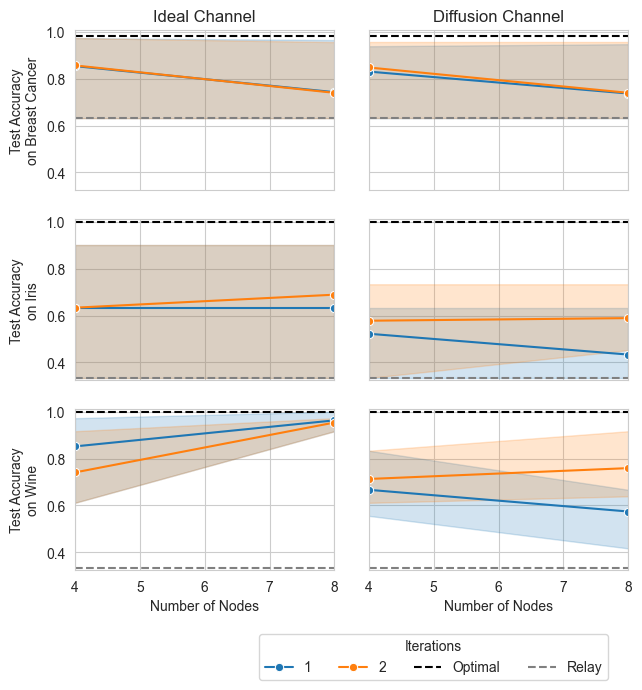

In [20]:
plot_results(df_res, df_res_nn, output_fig=os.path.join("results_cls.png"))